In [1]:
# Remember: library imports are ALWAYS at the top of the script, no exceptions!
import sqlite3
import os
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from math import ceil
import warnings
warnings.filterwarnings('ignore')
import dtale
from MulticoreTSNE import MulticoreTSNE as mcTSNE

from sklearn.impute import KNNImputer
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

from itertools import product
from pandas_profiling import ProfileReport
# from prince import MCA

%config InlineBackend.figure_format = 'retina'

# Seeting seaborn style
sns.set()

from datetime import datetime
# import calendar
# import missingno as msno
from sklearn.impute import SimpleImputer
import scipy.stats as ss


from helper_functions import *
template = "plotly_dark"

colors = (["#505050", "#d1675b"])
import plotly.express as px
%load_ext autoreload
%autoreload 2

In [3]:
data = pd.read_pickle("datasets/data_NN_Imputed.pkl")

In [4]:
features = ['DOMAIN', 'STATE', 'AGE', 'INCOME', 'GENDER', 'RECENCY', 'FREQUENCY', 'AMOUNT', 'RAMNTALL', 
            'NGIFTALL', 'LASTGIFT', 'AVGGIFT', 'LASTDATE_MONTHS', 'FIRSTDATE_MONTHS']
data_fin = data[features].copy().reset_index(drop=True)

In [5]:
metric_features = ['AGE','RAMNTALL', 'LASTGIFT', 'NGIFTALL',  'AVGGIFT','LASTDATE_MONTHS', 'FIRSTDATE_MONTHS']

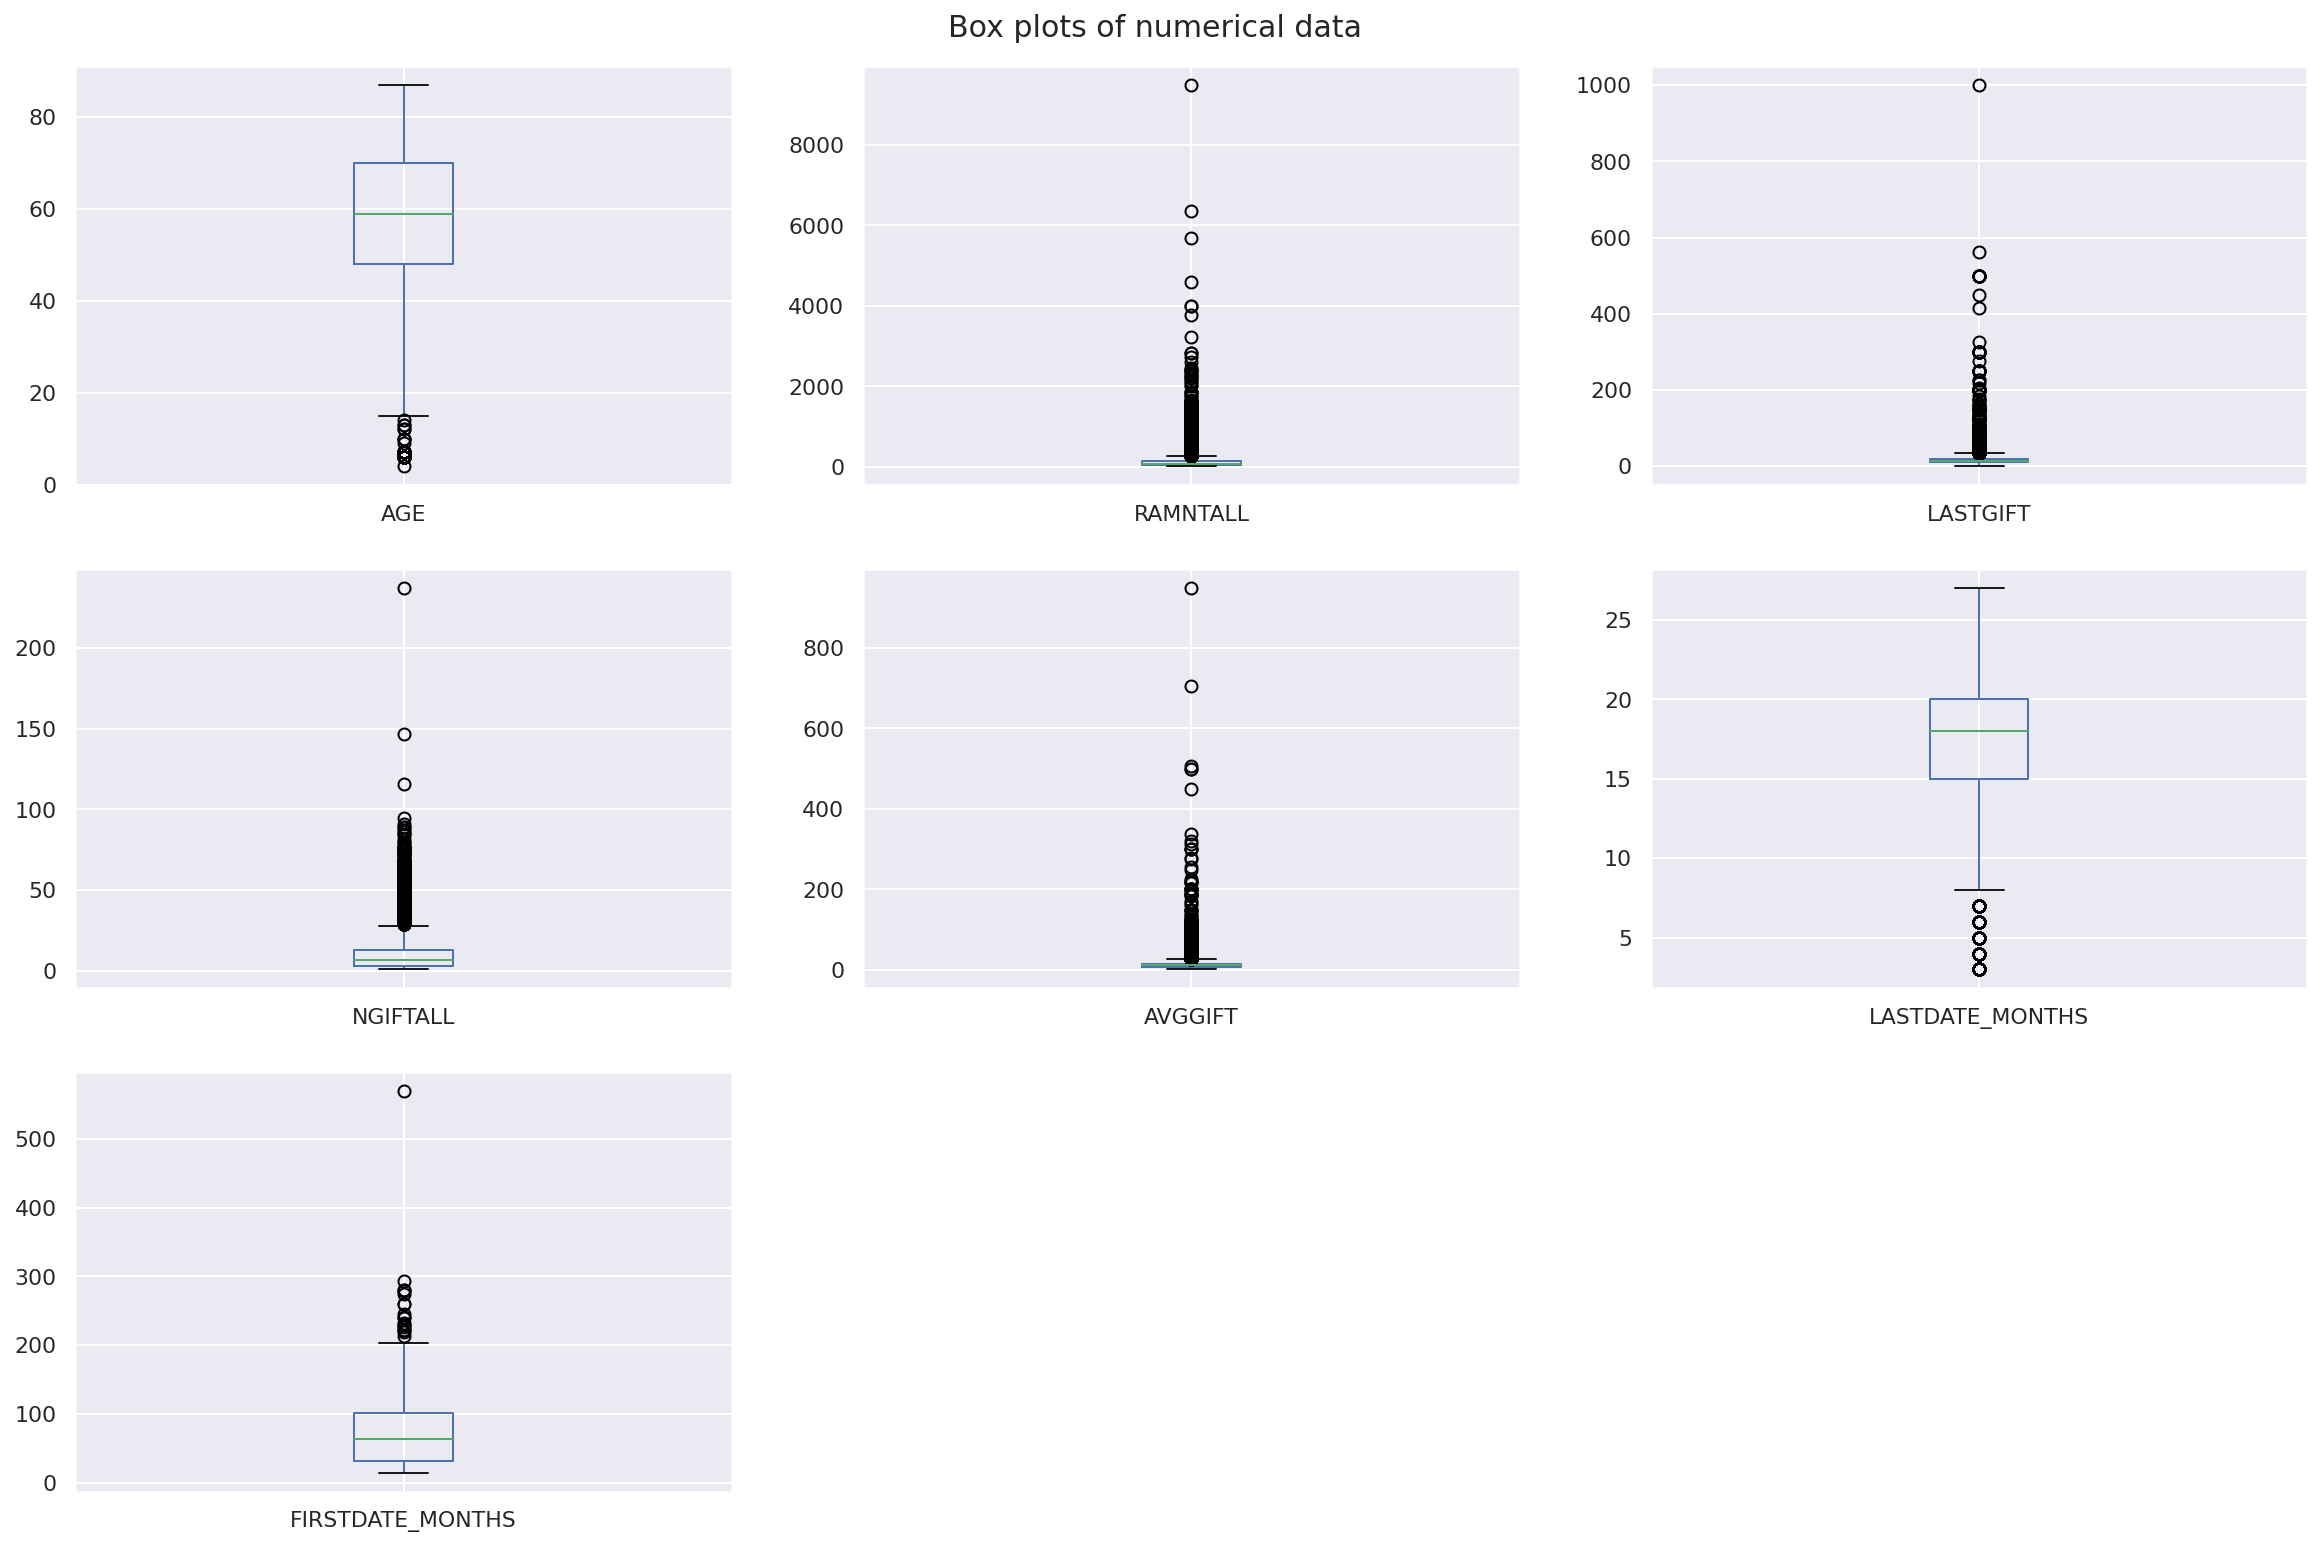

In [6]:
# box and whisker plots
sns.set()

# set box plot and layout
data_fin[metric_features].plot(kind='box', subplots=True, layout=(3,3), figsize=(20,12), sharex=False, sharey=False)
plt.subplots_adjust(top=0.95)
plt.suptitle("Box plots of numerical data", fontsize=15)

plt.show()

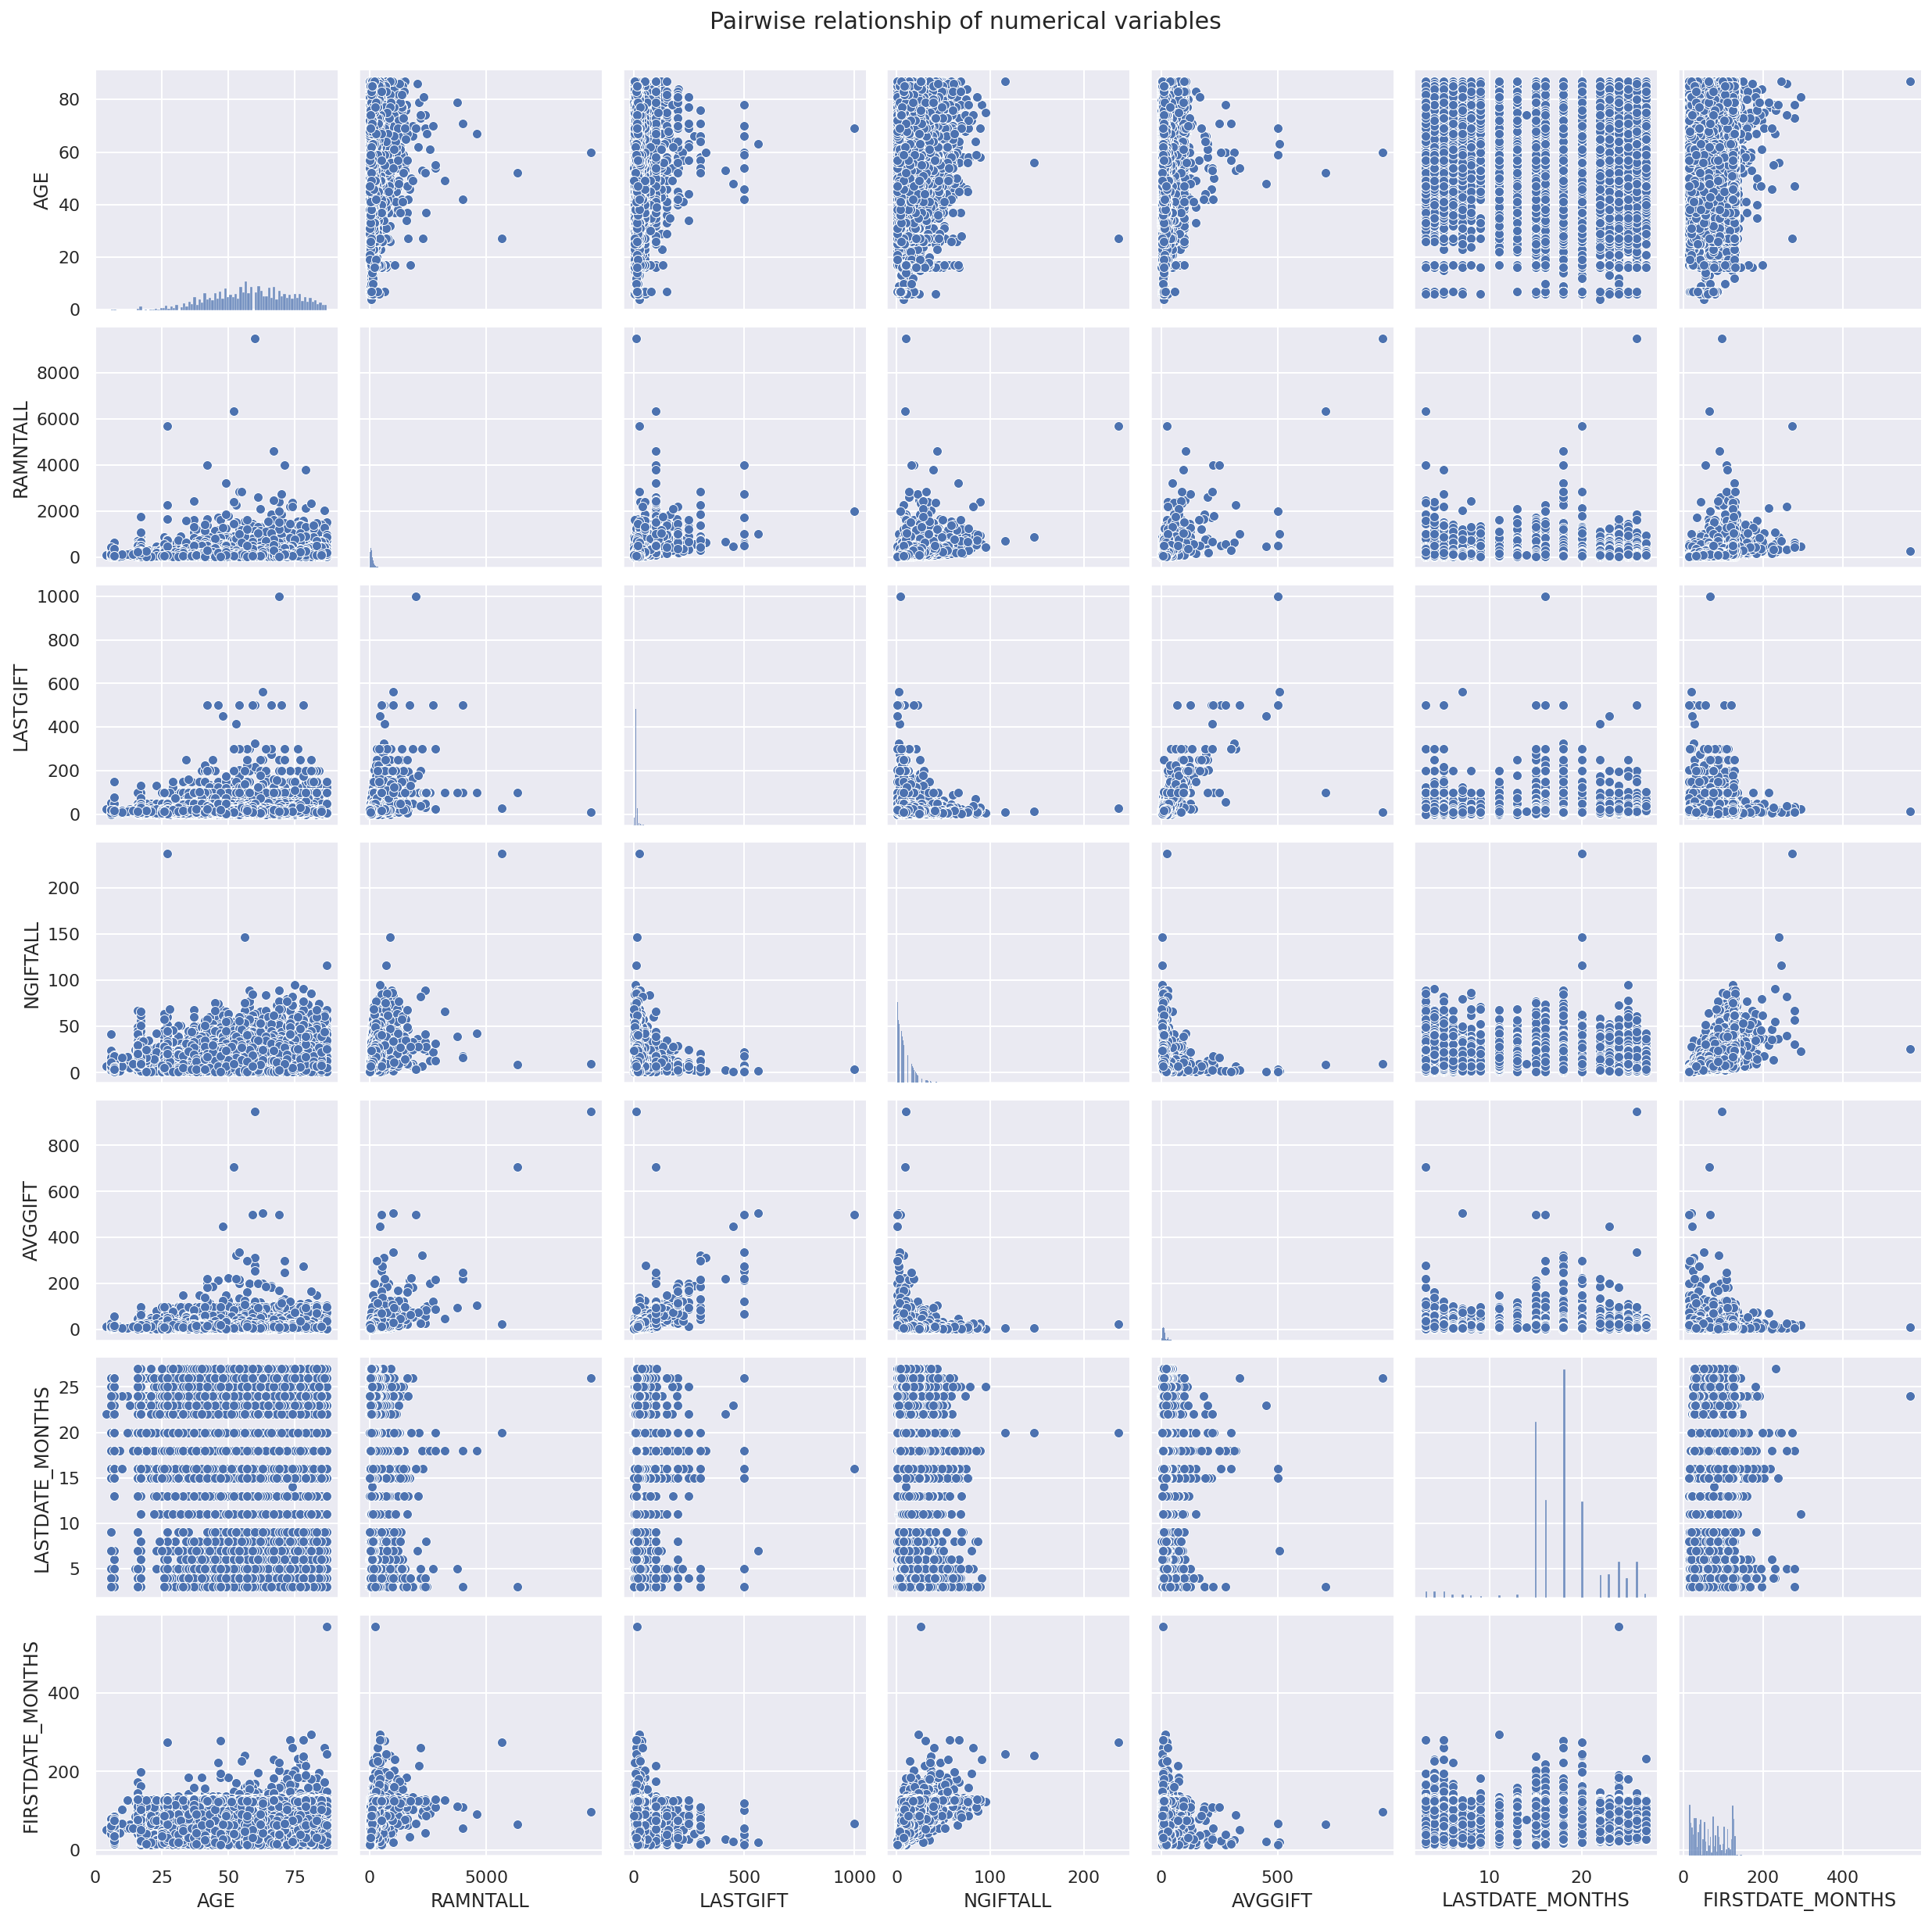

In [7]:
# pairwise relationship of numerical Variables
sns.set()

# set pairplot and layout
sns.pairplot(data_fin[metric_features], diag_kind="hist")
plt.subplots_adjust(top=0.95)
plt.suptitle("Pairwise relationship of numerical variables", fontsize=15)

plt.show()

#### Metric variables correlation

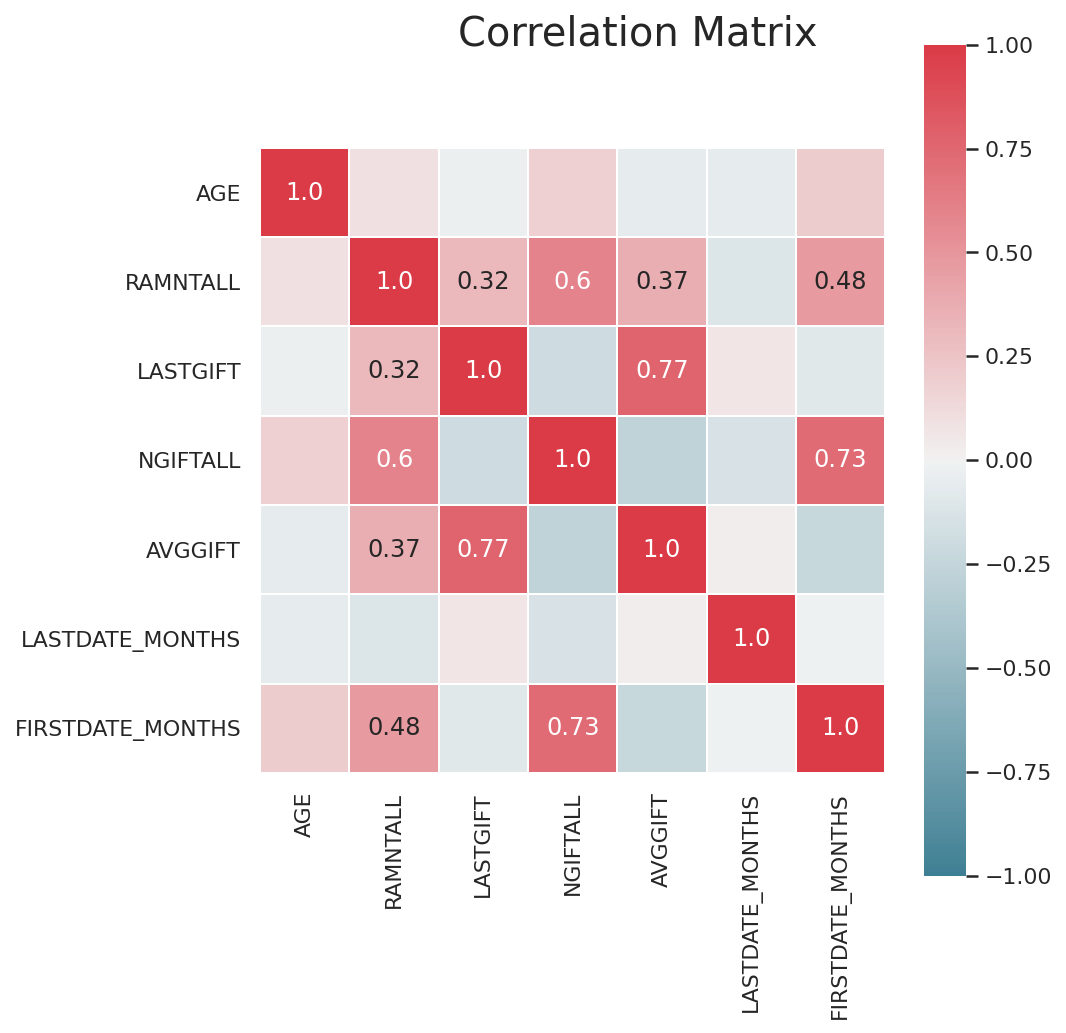

In [8]:
# Prepare figure
fig = plt.figure(figsize=(7, 7))

# Obtain correlation matrix. Round the values to 2 decimal cases. Use the DataFrame corr() and round() method.
corr = np.round(data_fin[metric_features].corr(method="pearson"), decimals=2)

# Build annotation matrix (values above |0.3| will appear annotated in the plot)
mask_annot = np.absolute(corr.values) >= 0.3
annot = np.where(mask_annot, corr.values, np.full(corr.shape,"")) # Try to understand what this np.where() does

# Plot heatmap of the correlation matrix
sns.heatmap(data=corr, annot=annot, cmap=sns.diverging_palette(220, 10, as_cmap=True), 
            fmt='s', vmin=-1, vmax=1, center=0, square=True, linewidths=.5)

# Layout
fig.subplots_adjust(top=0.95)
fig.suptitle("Correlation Matrix", fontsize=20)
plt.show()

We see high correlation between NGIFTALL and FIRSTDATE_MONTHS 
(a bit obvious - the earlier people joined - more times they donated). 
And LASTGIFT is highly correlated with AVGGIFT.

#### Categorical variables association

In [9]:
# Cramer's V - implemetation was taken from link - https://towardsdatascience.com/the-search-for-categorical-correlation-a1cf7f1888c9
def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x,y)
    chi2 = ss.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2/n
    r,k = confusion_matrix.shape
    phi2corr = max(0, phi2-((k-1)*(r-1))/(n-1))
    rcorr = r-((r-1)**2)/(n-1)
    kcorr = k-((k-1)**2)/(n-1)
    return np.sqrt(phi2corr/min((kcorr-1),(rcorr-1)))

In [10]:
# To get information about so-correlated categorical variables
# we build Correlation matrix based on Cramer's V for all categorical variables 
rows = []
cat_features = ['DOMAIN', 'STATE', 'INCOME', 'GENDER', 'RECENCY', 'AMOUNT']
dataframe = data_fin[cat_features].copy()

for var1 in dataframe:
    col = []
    for var2 in dataframe :
        cramers =cramers_v(dataframe[var1], dataframe[var2]) # Cramer's V
        col.append(round(cramers,3)) # Keeping of the rounded value of the Cramer's V  
    rows.append(col)

cramers_array = np.array(rows)
dataframe = pd.DataFrame(cramers_array, columns = dataframe.columns, index = dataframe.columns)

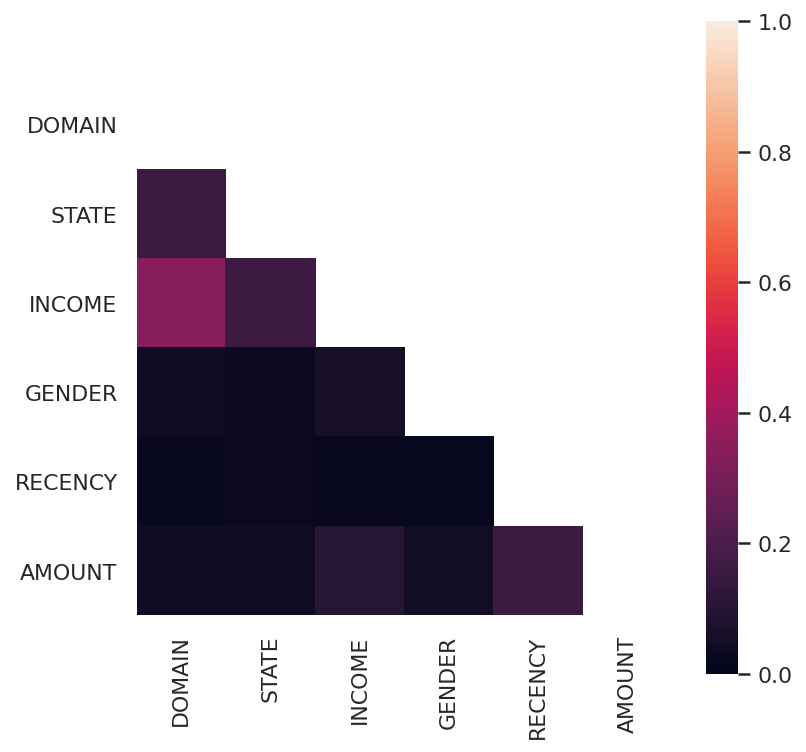

In [11]:
# Build heatmap plot to visualize association matrix for categorical features
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize = (6,6))
mask = np.zeros_like(dataframe, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

with sns.axes_style("white"):
    ax = sns.heatmap(dataframe, mask = mask, vmin = 0., vmax=1, square=True)

plt.show()

#### PCA for Census data 

In [12]:
pca_features = ['AGEC6', 'HHD7', 'HHD11', 'LFC3', 'LFC4', 'LFC5', 
                'EC2', 'EC3', 'EC4', 'EC5', 'EC6', 'EC7', 'EC8' ]

In [13]:
# Scale metric variables and variables chosen for PCA
scaler = StandardScaler()
pca_columns = data[pca_features].copy().reset_index(drop=True)

In [14]:
pca_columns[pca_columns.columns.tolist()] = scaler.fit_transform(pca_columns)
data_fin[metric_features] = scaler.fit_transform(data_fin[metric_features])

In [15]:
# Print normalized PCA columns
pca_columns

,AGEC6,HHD7,HHD11,LFC3,LFC4,LFC5,EC2,EC3,EC4,EC5,EC6,EC7,EC8
0,0.076568,-0.354471,-0.417101,-0.442595,-0.392213,-0.656144,0.873613,-0.374842,1.000212,0.027784,0.426383,-1.035283,-0.618552
1,-1.092023,-0.731600,-1.595278,0.141145,0.747168,0.292063,-0.455339,-1.032706,-1.634836,0.027784,0.132215,1.638585,1.793472
2,-0.090373,-0.165907,-0.202887,0.214113,0.009921,0.219124,1.598495,0.940887,-0.073326,-0.675346,-0.161954,-0.932442,-0.618552
3,-0.591198,-0.354471,-0.738422,-0.223693,-0.124124,-0.583205,2.323378,-0.111696,-1.439647,0.871540,1.014719,-1.138124,-0.334785
4,0.243510,2.285432,0.439755,-0.369628,-0.325191,-0.291449,0.873613,0.940887,0.121863,-1.097224,-1.044458,-0.212554,-0.334785
...,...,...,...,...,...,...,...,...,...,...,...,...,...
93362,-1.258965,0.776916,-0.417101,1.235659,0.881213,1.167331,-0.817780,-0.769560,-0.073326,1.715296,0.426383,0.095969,0.090867
93363,-1.092023,-1.108729,-1.488171,-0.004790,1.149302,-0.072632,-0.938594,-0.901133,-1.634836,0.449662,0.132215,2.255632,0.942169
93364,-0.257315,1.531174,0.118434,0.943789,0.009921,1.167331,-0.455339,-1.295852,2.171344,0.309036,0.132215,-0.315395,-1.044204
93365,-0.591198,0.022658,-0.738422,0.287080,1.015258,0.292063,-0.213712,-0.901133,-0.854081,1.996548,1.603056,0.095969,-0.334785


In [16]:
pca = PCA()
pca.fit(pca_columns)

PCA()

In [17]:
# Output PCA table
pd.DataFrame(
    {"Eigenvalue": pca.explained_variance_,
     "Difference": np.insert(np.diff(pca.explained_variance_), 0, 0),
     "Proportion": pca.explained_variance_ratio_,
     "Cumulative": np.cumsum(pca.explained_variance_ratio_)},
    index=range(1, pca.n_components_ + 1)
)

,Eigenvalue,Difference,Proportion,Cumulative
1,4.653096,0.000000,0.357927,0.357927
2,2.512183,-2.140914,0.193243,0.551169
3,1.288395,-1.223788,0.099106,0.650276
4,1.076649,-0.211745,0.082818,0.733094
5,0.895184,-0.181465,0.068860,0.801953
6,0.700412,-0.194772,0.053877,0.855831
7,0.472446,-0.227967,0.036342,0.892172
8,0.422127,-0.050318,0.032471,0.924643
9,0.352648,-0.069479,0.027126,0.951770
10,0.293040,-0.059608,0.022541,0.974311


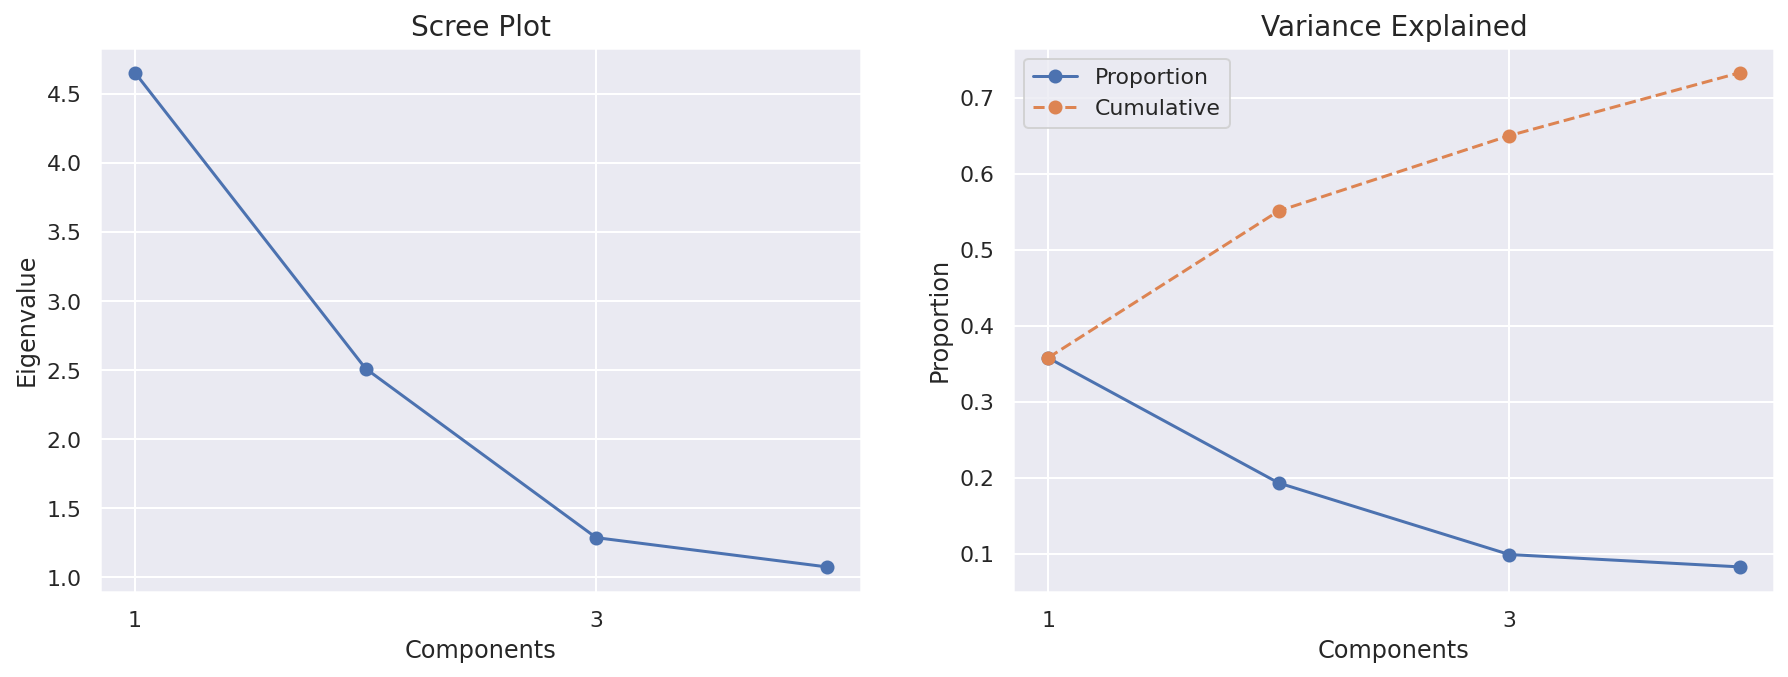

In [23]:
# figure and axes
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# draw plots
ax1.plot(pca.explained_variance_, marker=".", markersize=12)
ax2.plot(pca.explained_variance_ratio_, marker=".", markersize=12, label="Proportion")
ax2.plot(np.cumsum(pca.explained_variance_ratio_), marker=".", markersize=12, linestyle="--", label="Cumulative")

# customizations
ax2.legend()
ax1.set_title("Scree Plot", fontsize=14)
ax2.set_title("Variance Explained", fontsize=14)
ax1.set_ylabel("Eigenvalue")
ax2.set_ylabel("Proportion")
ax1.set_xlabel("Components")
ax2.set_xlabel("Components")
ax1.set_xticks(range(0, pca.n_components_, 2))
ax1.set_xticklabels(range(1, pca.n_components_ + 1, 2))
ax2.set_xticks(range(0, pca.n_components_, 2))
ax2.set_xticklabels(range(1, pca.n_components_ + 1, 2))

plt.show()

From graphs we see that number between 3-7 is ok to choose

Using Kaiser’s Criterion, where PCs with an eigenvector greater than 1.0 should be retained we are going to leave first 4 PCs.
https://en.wikipedia.org/wiki/Factor_analysis#Older_methods


In [24]:
# Perform PCA again with the number of principal components you want to retain
pca = PCA(n_components = 4)
data_fin[(pca_feat_names := [f"PC{i}" for i in range(pca.n_components_)])] = pca.fit_transform(pca_columns)

In [25]:
# Merge data_fin with pca variables to check their relationship
df_pca = pd.concat([data_fin, pca_columns], axis=1)
df_pca.head()

,DOMAIN,STATE,AGE,INCOME,GENDER,RECENCY,FREQUENCY,AMOUNT,RAMNTALL,NGIFTALL,...,LFC3,LFC4,LFC5,EC2,EC3,EC4,EC5,EC6,EC7,EC8
0,T2,IL,0.034385,0.0,0,L,4,C,1.148089,2.505245,...,-0.442595,-0.392213,-0.656144,0.873613,-0.374842,1.000212,0.027784,0.426383,-1.035283,-0.618552
1,S1,CA,-0.904638,2.0,1,L,2,F,-0.485953,-0.771696,...,0.141145,0.747168,0.292063,-0.455339,-1.032706,-1.634836,0.027784,0.132215,1.638585,1.793472
2,R2,NC,-0.166834,0.0,1,L,4,B,0.826361,2.037111,...,0.214113,0.009921,0.219124,1.598495,0.940887,-0.073326,-0.675346,-0.161954,-0.932442,-0.618552
3,R2,CA,0.705116,0.0,0,L,4,C,0.038973,0.749741,...,-0.223693,-0.124124,-0.583205,2.323378,-0.111696,-1.439647,0.871540,1.014719,-1.138124,-0.334785
4,S2,FL,1.241701,0.0,0,L,2,D,1.266621,3.207447,...,-0.369628,-0.325191,-0.291449,0.873613,0.940887,0.121863,-1.097224,-1.044458,-0.212554,-0.334785


In [26]:
def _color_red_or_green(val):
    if val < -0.45:
        color = 'background-color: red'
    elif val > 0.45:
        color = 'background-color: green'
    else:
        color = ''
    return color

# Interpreting each Principal Component
loadings = df_pca[metric_features + pca_features + pca_feat_names].corr().loc[metric_features + pca_features, pca_feat_names]
loadings.style.applymap(_color_red_or_green)

,PC0,PC1,PC2,PC3
AGE,0.118126,0.151700,-0.050228,0.099163
RAMNTALL,0.001632,0.055369,-0.015978,0.015564
LASTGIFT,-0.056383,0.048237,0.033572,-0.007980
NGIFTALL,0.068443,0.015962,-0.052720,0.023674
AVGGIFT,-0.070468,0.048687,0.043182,-0.006416
LASTDATE_MONTHS,-0.005015,-0.026955,0.007998,-0.022184
FIRSTDATE_MONTHS,0.057894,0.038458,-0.053397,0.019644
AGEC6,0.471628,0.535459,-0.394311,0.309864
HHD7,0.288479,-0.560141,0.373256,0.281320
HHD11,0.209478,0.311165,0.130661,0.842339


So in the begining of my PCA analyses i used PCA with n = all (corresponds to number of variables), did analysis - how many PCs to choose in the end, to save as much information from 13 initial variables, analysis (elbow method and other criteria) showed 4. So i ended up with 4. It is like these 4 informationally almost equivalent to our initial 13 census variables (they explain near 75% variance in our 13 variables, looking at the graphs).
But PC0 is the strongest one, it has the most information about our 13 variables.
In general if we are not going to use these census variables (and i was not going, who needs these census crap?) we just take PC-s instead of them, and as these features are not really, really important to us - we can use only first (PC0).

In [27]:
cut_labels_4 = ['1', '2', '3', '4']

data_fin['SES_index'] = np.log(data_fin.PC0)
std = np.std(data_fin.SES_index)
cut_bins = [-np.inf, (-1)*std, 0, std, np.inf]
data_fin['SES_index'] = pd.cut(data_fin.PC0, bins=cut_bins, labels=cut_labels_4)

In [28]:
# To get information about so-correlated categorical variables
# we build Correlation matrix based on Cramer's V for all categorical variables 
rows = []
cat_features = ['DOMAIN', 'STATE', 'INCOME', 'GENDER', 'RECENCY', 'AMOUNT', 'SES_index']
dataframe = data_fin[cat_features].copy()

for var1 in dataframe:
    col = []
    for var2 in dataframe :
        cramers =cramers_v(dataframe[var1], dataframe[var2]) # Cramer's V
        col.append(round(cramers,3)) # Keeping of the rounded value of the Cramer's V  
    rows.append(col)

cramers_array = np.array(rows)
dataframe = pd.DataFrame(cramers_array, columns = dataframe.columns, index = dataframe.columns)

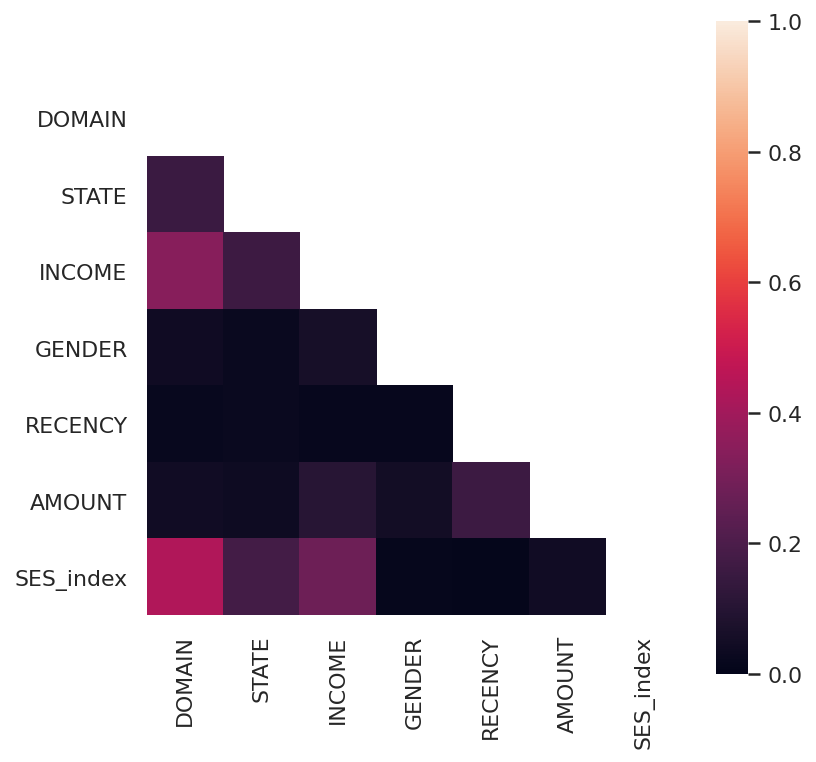

In [29]:
# Build heatmap plot to visualize association matrix for categorical features
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize = (6,6))
mask = np.zeros_like(dataframe, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

with sns.axes_style("white"):
    ax = sns.heatmap(dataframe, mask = mask, vmin = 0., vmax=1, square=True)

plt.show()

In [30]:
data_fin.to_pickle("datasets/data_PCA.pkl")